### Домашня работа №4
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. (опционально) построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево  
Ссылки:  
https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0  
https://habr.com/ru/company/ru_mts/blog/485980/#reference1  
https://en.wikipedia.org/wiki/Uplift_modelling  
https://www.youtube.com/watch?v=yFQAIJBYXI0  
https://www.youtube.com/watch?v=jCUcYiBK03I  
https://www.uplift-modeling.com/en/latest/  
https://arxiv.org/pdf/1809.04559.pdf  
https://catboost.ai/docs/concepts/about.html  
Библиотеки и пакеты:  
causalml  
sklift  
catboost  

### Наименования и значения столбцов таблицы данных
recency	history -
месяцы с момента последней покупки


history -
Стоимость исторических покупок в долларах США

used_discount -
указывает, использовал ли клиент скидку ранее

used_bogo -
указывает, использовал ли клиент buy one get one ранее

zip_code -
класс почтового индекса как пригородный / Городской / Сельский

is_referral -
указывает, был ли клиент привлечен через реферальный канал

channel -
каналы, которые использует клиент, телефонные / Веб / Многоканальные

offer -
предложения, отправленные клиентам, со скидкой / Но один получает одно / Без предложения

conversion -
конверсия клиентов (покупал или нет)

Импортируем нужные библиотеки и предобработаем данные:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
df_clients_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/4 - Uplift-моделирование/Домашняя работа/data.csv')
df_clients_all

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


###  2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
df_clients_all = df_clients_all.rename(columns = {'offer': "treatment", 'conversion': "target"})
df_clients_all['treatment'] = np.where((df_clients_all.treatment == 'No Offer'), 0, 1)
df_clients_all

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [4]:
df_clients_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [5]:
df_clients = df_clients_all.drop(['treatment', 'target'], 1)
df_clients

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web
63996,5,38.91,0,1,Urban,1,Phone
63997,6,29.99,1,0,Urban,1,Phone
63998,1,552.94,1,0,Surburban,1,Multichannel


In [6]:
train, test = train_test_split(df_clients_all, test_size=0.3, random_state=123)
df_train = train[['treatment',	'target']]
df_test = test[['treatment',	'target']]
df_train

,treatment,target
53181,0,0
42635,1,0
6296,0,1
41722,1,0
32660,1,0
...,...,...
61404,1,0
17730,1,0
28030,0,1
15725,1,1


In [7]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [8]:
df_train.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,14902.0,0.106563,0.308567,0.0,0.0,0.0,0.0,1.0
1,29898.0,0.166734,0.372744,0.0,0.0,0.0,0.0,1.0


Заведем переменные

In [9]:
X_train = df_clients.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_clients.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_clients.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_clients.loc[indices_test, :]

cat_features = (['zip_code', 'channel'])

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Пропусков нет. Пока feature engineering делать не буду

### 5. провести uplift-моделирование 3 способами: 


In [10]:
# pip install catboost

#### 5.1. Модель с признаком коммуникации (S learner)

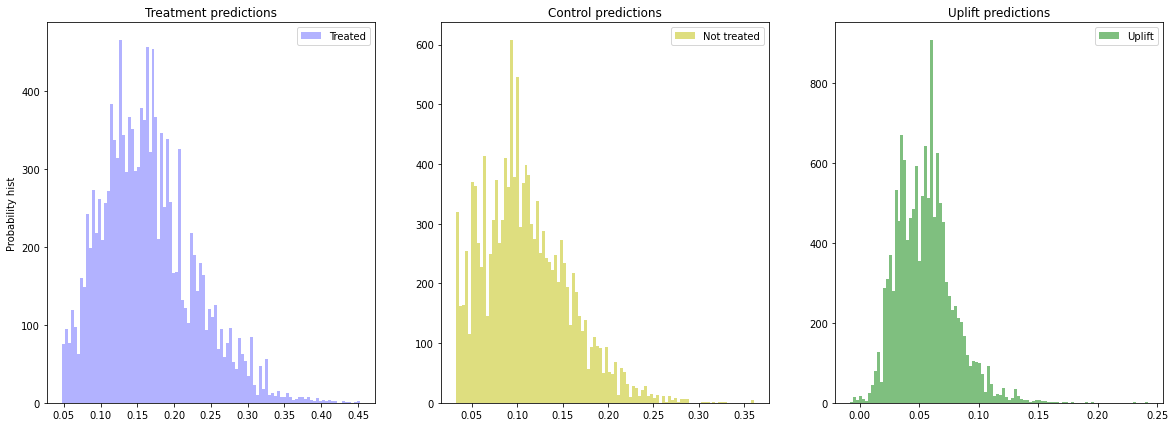

In [11]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [12]:
sm_score_10

0.08350118750563687

In [13]:
sm_score_20

0.09012951523439994

In [14]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.185664
1,treatment,16.630192
2,recency,13.754215
3,used_bogo,12.287104
4,channel,10.403275
5,history,9.763462
6,zip_code,9.599321
7,used_discount,6.376770


#### 5.2. Модель с трансформацией таргета


In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

In [16]:
sm_score_10

0.11028019120343924

In [17]:
sm_score_20

0.08616122650964514

In [18]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,26.048348
1,recency,20.323703
2,used_bogo,18.471698
3,is_referral,14.471426
4,used_discount,8.341713
5,zip_code,7.472119
6,channel,4.870993


#### 5.3. Dариант с двумя независимыми моделями

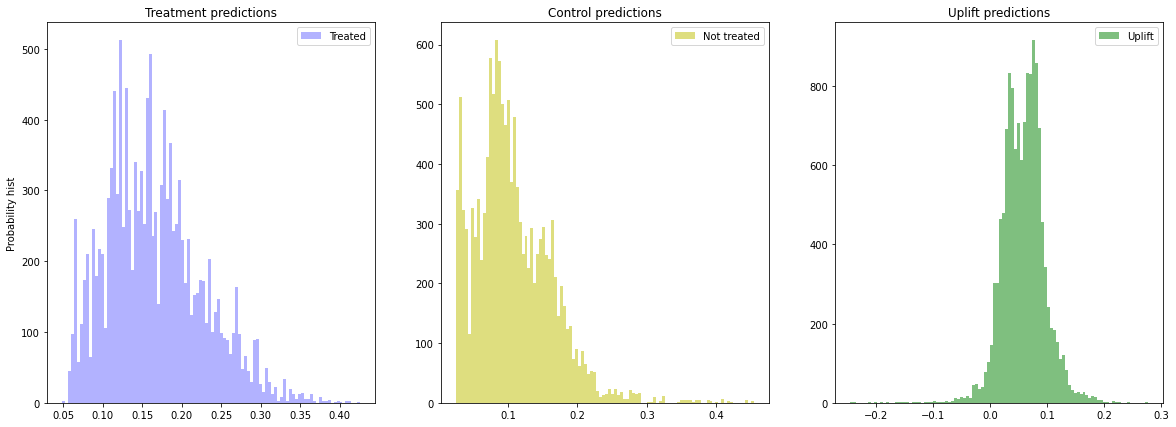

In [19]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [20]:
sm_score_10

0.12865646514144843

In [21]:
sm_score_20

0.09487919961061597

### 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [22]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.128656,0.094879
1,ClassTransformation,0.110280,0.086161
0,SoloModel,0.083501,0.090130


### 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [23]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
62674,4,113.37,0,1,Urban,1,Phone
14843,10,380.21,1,1,Urban,0,Web
10986,10,34.97,1,0,Rural,1,Web
2212,9,118.01,0,1,Surburban,0,Web
46320,2,132.16,0,1,Urban,0,Web
...,...,...,...,...,...,...,...
23065,6,896.19,1,1,Surburban,1,Phone
17118,4,168.57,1,0,Rural,1,Phone
50416,12,58.60,0,1,Urban,1,Web
56758,9,91.37,1,0,Surburban,1,Phone


In [24]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], 1), pd.get_dummies(X_train['zip_code'], 1), pd.get_dummies(X_train['channel'])], 1)
features = [col for col in X_train_tree]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [25]:
# pip install causalml

In [26]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPU times: user 3.01 s, sys: 316 ms, total: 3.33 s
Wall time: 4.19 s


In [27]:
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 '1_Rural',
 '1_Surburban',
 '1_Urban',
 'Multichannel',
 'Phone',
 'Web']

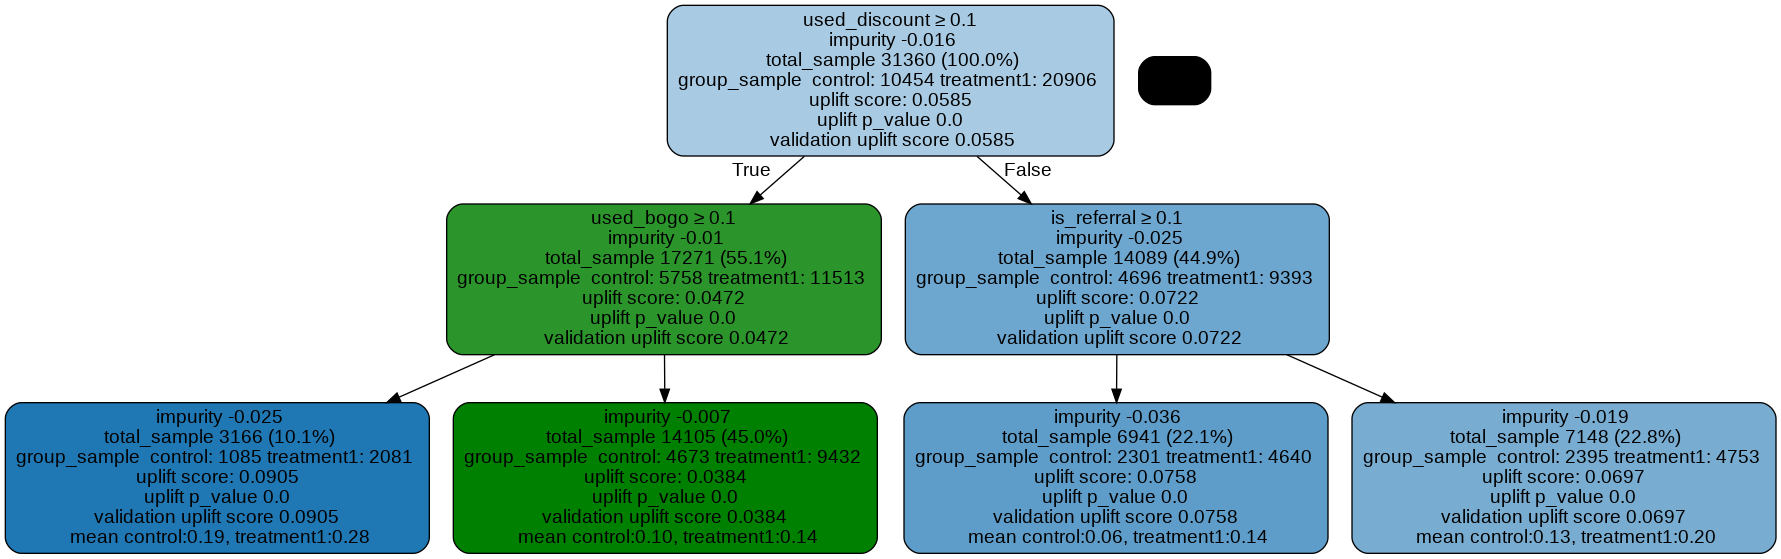

In [28]:
Image(graph.create_png())

#### Описание дерева:

Видим, что признаком, по которому происходит перволе разбиение является 'used_discount'. Рабиение выборки по этому признаку дает uplift_score на уровне 0.05. В следующих узлах деление происходит 'used_bogo' и 'is_referral' и в терминатьном узле с помощью дивергенции Кульбака-Лейблера при критерии разделения -0.025 можно выделить 10% выборки при uplift_score 0.09.Таким образом общий вывод можно сформулировать следующим умозаключением: бывшие клиенты, которые воспользовались скидкой и участвоавали в акции "Покупай одну вещь - вторую получай бесплатно" с большей вероятностью откликнутьчс на маркетинговую активность. 

### 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:  
#### 1) сделать прогноз и получить uplift для тестовой выборки  

In [29]:
df_clients

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web
63996,5,38.91,0,1,Urban,1,Phone
63997,6,29.99,1,0,Urban,1,Phone
63998,1,552.94,1,0,Surburban,1,Multichannel


In [30]:
X_test = df_clients.loc[indices_test, :]
X_test

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
19593,3,220.45,1,0,Surburban,0,Phone
4997,4,328.97,1,1,Rural,0,Phone
36682,4,29.99,1,0,Surburban,1,Phone
29881,1,50.82,1,0,Urban,1,Phone
25401,10,31.17,1,0,Surburban,0,Phone
...,...,...,...,...,...,...,...
39655,11,29.99,1,0,Surburban,1,Web
45479,1,43.30,1,0,Surburban,0,Phone
21007,2,40.94,0,1,Surburban,0,Phone
39923,1,245.09,0,1,Rural,1,Web


In [31]:
uplift_sm = sm.predict(X_test)
uplift_sm

array([0.04233324, 0.08213466, 0.02885187, ..., 0.05774985, 0.10674364,
       0.03613781])

#### 2) отсортировать тестовую выборку по uplift по убыванию  

In [32]:
test['uplift_sm'] = uplift_sm
test = test.sort_values('uplift_sm', ascending = False)
test

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_sm
25171,11,434.35,1,1,Urban,0,Web,1,0,0.199131
37792,11,418.24,1,1,Urban,0,Web,1,0,0.199131
41855,11,466.48,1,1,Urban,0,Web,0,0,0.199131
1292,5,210.92,1,1,Rural,1,Web,0,1,0.180691
58524,11,480.67,1,1,Urban,0,Multichannel,1,1,0.179129
...,...,...,...,...,...,...,...,...,...,...
5301,8,204.35,1,0,Surburban,0,Multichannel,1,0,-0.007751
19761,8,205.89,1,0,Urban,0,Multichannel,0,1,-0.007751
2484,8,217.06,1,0,Urban,0,Multichannel,0,0,-0.008252
11830,8,244.04,1,0,Rural,0,Multichannel,1,0,-0.011348


#### 3) разбить на децили (pandas qcut вам в помощь)

In [33]:
bin_labels_10 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

test['decile'] = pd.qcut(test['uplift_sm'],
                              q = 10,
                              labels=bin_labels_10)

In [34]:
test

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_sm,decile
25171,11,434.35,1,1,Urban,0,Web,1,0,0.199131,10
37792,11,418.24,1,1,Urban,0,Web,1,0,0.199131,10
41855,11,466.48,1,1,Urban,0,Web,0,0,0.199131,10
1292,5,210.92,1,1,Rural,1,Web,0,1,0.180691,10
58524,11,480.67,1,1,Urban,0,Multichannel,1,1,0.179129,10
...,...,...,...,...,...,...,...,...,...,...,...
5301,8,204.35,1,0,Surburban,0,Multichannel,1,0,-0.007751,1
19761,8,205.89,1,0,Urban,0,Multichannel,0,1,-0.007751,1
2484,8,217.06,1,0,Urban,0,Multichannel,0,0,-0.008252,1
11830,8,244.04,1,0,Rural,0,Multichannel,1,0,-0.011348,1


#### 4) для каждого дециля посчитать среднюю conversion

In [35]:
test.groupby('decile')['target'].mean()

decile
1     0.084896
2     0.125455
3     0.113825
4     0.127871
5     0.142783
6     0.138557
7     0.154812
8     0.167449
9     0.194516
10    0.219538
Name: target, dtype: float64

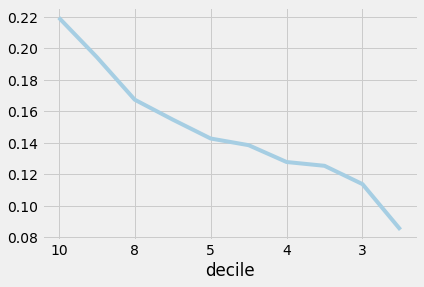

In [36]:
test.groupby('decile')['target'].mean().sort_values(ascending = False).plot()

#### Вывод:
Видим, что средний conversion, а следовательно и доля "1" больше в 10 делиле с самым большим уровнем uplift. Следловательно наша модель работает корректно и действительно отбирает клиентов, которые лучше реагируют на предложение. Дальше доля "1" постоянно снижается.

#### 9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево  

In [37]:
X_test_tree = pd.concat([X_test.drop(['zip_code', 'channel'], 1), pd.get_dummies(X_test['zip_code'], 1), pd.get_dummies(X_test['channel'])], 1)
features = [col for col in X_test_tree]
treat_test = df_test.loc[indices_test, 'treatment']
y_test = df_test.loc[indices_test, 'target']


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [38]:
%%time
from IPython.display import Image 
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier 
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 3, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')



CPU times: user 102 µs, sys: 10 µs, total: 112 µs
Wall time: 121 µs


In [39]:
uplift_model.fit(X_test_tree.values, treatment=treat_test.map({1: 'treatment1', 0: 'control'}).values, y=y_test.values)


In [40]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, features)

1_Rural >= 0.1?
yes -> history >= 389.3079999999998?
		yes -> [0.09644670050761421, 0.21409921671018275]
		no  -> [0.18875502008032127, 0.20305537873965626]
no  -> history >= 560.9929999999998?
		yes -> [0.11092436974789915, 0.21525096525096524]
		no  -> [0.09717675941080196, 0.15762036185219258]


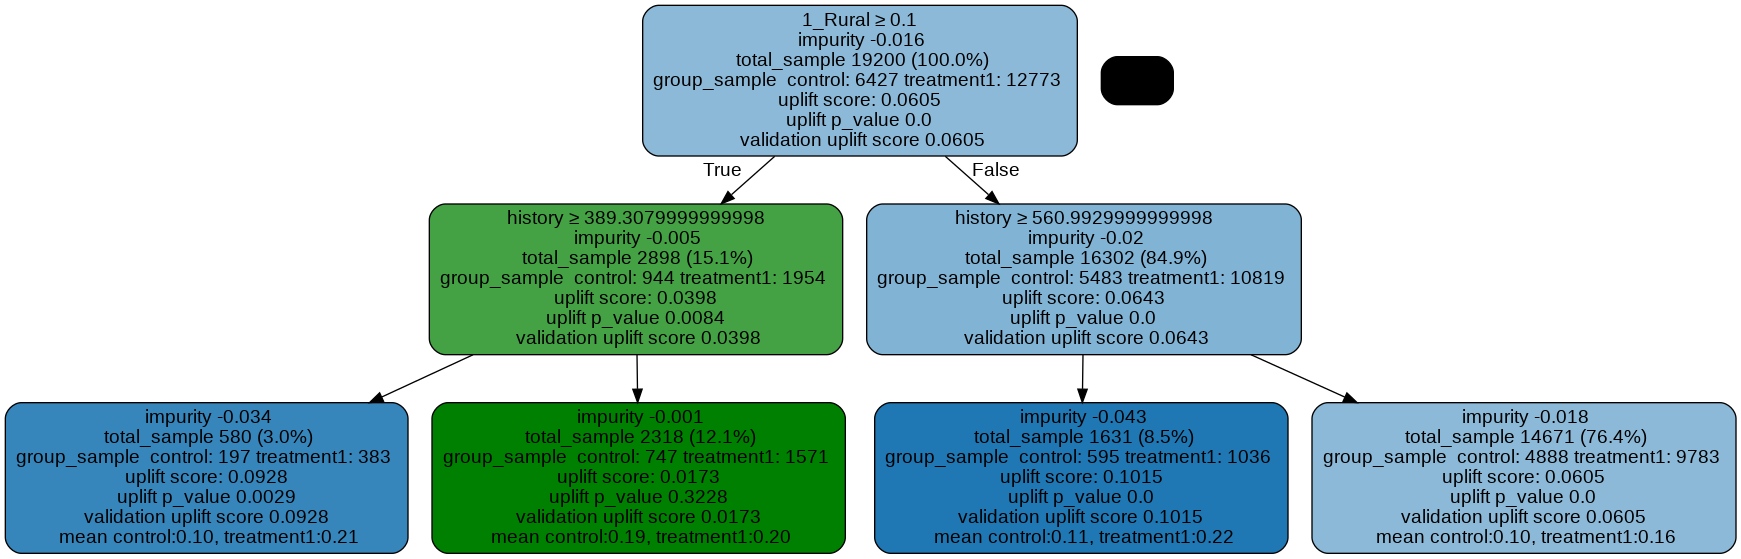

In [41]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features)
Image(graph.create_png())

#### Описание дерева:

Здесь сразу сформулирую общий вывод: несельские жители со стоимостью исторических покупок более 560 долларов США с большей вероятностью откликнутьчс на маркетинговую активность.

# <font color='red'> Вопрос ревьюеру <font color='black'>

Эрик, не совсем понял как интерепретировать impurity в терминальных узлах. Подскажите, пожалуйста, как это правильно понимать. 